In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_noise(shape):
    noise = np.random.rand(*shape) 
    noise =  noise/noise.std() * np.mean([img.std() for img in pred])
    noise = noise.astype(np.int32) - noise.mean() + pred.mean()
    return noise

def add_metric_text(ax, text, img_shape, place='TOP_LEFT', edgecolor='black'):
    """
    Adding text on image
    """
    assert place in ['TOP_LEFT', 'BOTTOM_RIGHT']
    if place == 'TOP_LEFT':
        ax.text(img_shape[1] * 15 / 300, img_shape[0] * 55 / 300, text, bbox=dict(facecolor='white', edgecolor=edgecolor, alpha=0.7))
    elif place == 'BOTTOM_RIGHT':
        s0 = img_shape[1]
        s1 = img_shape[0]
        ax.text(s0 - s0 * 150 / 300, s1 - s1 * 35 / 300, text, bbox=dict(facecolor='white', edgecolor=edgecolor, alpha=0.7))


In [3]:
from microssim import MicroSSIM, MicroMS3IM
from disentangle.core.tiff_reader import load_tiff

debug_mode = True

gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-31.tif'
pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-31.tif'
noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/actin-60x-noise2-lowsnr.tif'

# gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-29.tif'
# pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-29.tif'
# noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/mito-60x-noise2-lowsnr.tif'

# denoiSplit
# gt_path = '/group/jug/ashesh/downloads/Actin_HighSNR.tif'
# pred_path = '/group/jug/ashesh/downloads/Actin_pred.tif'
# noisy_gt_path = gt_path

# gt_path = '/group/jug/ashesh/downloads/Mito_HighSNR.tif'
# pred_path = '/group/jug/ashesh/downloads/Mito_pred.tif'
# noisy_gt_path = gt_path

gt = load_tiff(gt_path)
pred = load_tiff(pred_path)
gt_lowsnr = load_tiff(noisy_gt_path)


In [4]:
idx = 0 
gt_img = gt[idx]
pred_img = pred[idx]
gt_lowsnr_img = gt_lowsnr[idx]


In [5]:
q_vals = [0.01, 0.02, 0.98, 0.99]
gt_lowqvals = np.quantile(gt_lowsnr_img, q_vals)
pred_qvals = np.quantile(pred_img, q_vals)
gt_qvals = np.quantile(gt_img, q_vals)
print(f'GT LowSNR: {gt_lowqvals}')
print(f'Pred: {pred_qvals}')
print(f'GT: {gt_qvals}')


GT LowSNR: [ 96.  98. 115. 117.]
Pred: [102.51714348 102.69861603 110.34394699 111.58853127]
GT: [100. 101. 883. 999.]


In [14]:
from skimage.metrics import structural_similarity as ssim
def preprocessingV2(gt, pred,q_low=0.03,q_high=0.99, q_back=0.03):
    gt_low = np.quantile(gt, q_low)
    gt_high = np.quantile(gt, q_high)
    pred_low = np.quantile(pred, q_low)
    pred_high = np.quantile(pred, q_high)
    # print(gt_low, gt_high, pred_low, pred_high)
    factor = (gt_high - gt_low) / (pred_high - pred_low)
    # print('factor', factor) 
    pred = pred * factor
    # print(gt_high - gt_low, np.quantile(pred, q_high) - np.quantile(pred, q_low))
    # remove the background from both images
    gt_back = np.quantile(gt, q_back)
    pred_back = np.quantile(pred, q_back)
    # print('prediction after scaling', pred.min(), pred.max())
    # print('backgrounds', gt_back, pred_back)
    gt = gt - gt_back
    pred = pred - pred_back    
   
    return gt, pred

def ssimV2(gt, pred, q_low=0.03,q_high=0.99, q_back=0.03):
    gt, pred = preprocessingV2(gt, pred, q_low, q_high, q_back)
    # gt[gt < 0] = 0
    # pred[pred < 0] = 0
    # compute the SSIM
    return ssim(gt, pred, data_range=gt.max() - gt.min())


In [15]:
gt_proc, pred_proc = preprocessingV2(gt_img, pred_img)

In [16]:
pred_img[:20,:20]

array([[104.73870087, 104.36890411, 103.85646057, 104.90499878,
        104.25687408, 104.43267822, 105.27850342, 105.04405212,
        105.04476929, 105.33356476, 104.06867218, 104.6915741 ,
        105.95998383, 104.89571381, 104.14183044, 104.89066315,
        104.7647171 , 105.00566101, 104.55475616, 104.00766754],
       [103.91884613, 104.20540619, 104.64837646, 104.27901459,
        104.18160248, 103.97663116, 103.95095825, 105.01802826,
        105.18305969, 105.13052368, 104.75447845, 104.10905457,
        104.32009888, 104.59095001, 104.702034  , 104.26544189,
        104.85218048, 104.05272675, 104.33488464, 103.7636795 ],
       [103.89318085, 103.49224091, 104.75908661, 104.97891235,
        104.46934509, 103.88140106, 103.94476318, 104.27799225,
        104.41369629, 105.03413391, 104.9147644 , 105.19497681,
        104.43106079, 103.96159363, 105.00184631, 103.10588837,
        104.10459137, 104.30046844, 104.8319397 , 104.38506317],
       [104.53115082, 103.93748474, 1

In [17]:
import numpy as np
print(ssimV2(gt_img, gt_img))
noise = get_noise(gt_img.shape)
print(ssimV2(gt_img, pred_img))

1.0
0.27713026564776366


In [52]:
from microssim._micro_ssim_internal import micro_SSIM

def luminance_without_C1(alpha, ux, uy):
    num = 2 * alpha * ux * uy
    den = ux**2 + (alpha**2) * uy**2
    return num, den

def contrast_without_C2(alpha, vx, vy):
    num = 2 * alpha * np.sqrt(vx * vy)
    den = vx + (alpha**2) * vy
    return num, den

def structure_without_C2(alpha, vx, vy, vxy):
    num = 2 * alpha * vxy
    den = 2 * alpha * np.sqrt(vx * vy + 1e-10)
    return num, den


def get_multiplicative_factor_to_C(ssim_dict):
    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )
    alpha = ssim_dict['alpha']
    num_luminance, den_luminance = luminance_without_C1(alpha, ux, uy)
    num_contrast, den_contrast = contrast_without_C2(alpha, vx, vy)
    num_structure, den_structure = structure_without_C2(alpha, vx, vy, vxy)

    luminance_factors = np.minimum(np.abs(C1/num_luminance), np.abs(C1/den_luminance))
    contrast_factors = np.minimum(np.abs(C2/num_contrast), np.abs(C2/den_contrast))
    structure_factors = np.minimum(np.abs(C2/num_structure), np.abs(C2/den_structure))
    return luminance_factors, contrast_factors, structure_factors

def get_saturation_factor(gt, pred):
    gt, pred = preprocessingV2(gt, pred)
    print(gt.shape, pred.shape)
    ssim_dict = micro_SSIM(gt, pred, 
                            ri_factor=1.0,
                            data_range=gt.max() - gt.min(), return_individual_components=True)
    print(ssim_dict.keys())
    ssim_dict['saturation'] = get_multiplicative_factor_to_C(ssim_dict)
    return ssim_dict


897.0 897.0


In [58]:
pred_proc[:20,:20]

array([[197.32446582, 159.55159765, 107.20808132, 214.31095659,
        148.10829672, 166.06580035, 252.46256654, 228.51455253,
        228.58780711, 258.086804  , 128.88442397, 192.51070459,
        322.0723438 , 213.36254354, 136.35717068, 212.84664425,
        199.98189269, 224.59309446, 178.53544474, 122.65310864],
       [113.58045068, 142.85111147, 188.09828496, 150.36983712,
        140.41968278, 119.48289969, 116.8605415 , 225.85634635,
        242.71347265, 237.34718484, 198.93606663, 133.0092804 ,
        154.56638953, 182.23246324, 193.57913047, 148.98345518,
        208.91583453, 127.25567847, 156.07668081,  97.73096455],
       [110.9588718 ,  70.00488442, 199.40676629, 221.8608544 ,
        169.8111357 , 109.75562632, 116.2277466 , 150.26541038,
        164.12689183, 227.50145724, 215.3084658 , 243.9307456 ,
        165.90058789, 117.94689137, 224.20344243,  30.54092642,
        132.55338752, 152.56124016, 206.84834083, 161.20216366],
       [176.12427796, 115.48429052, 1

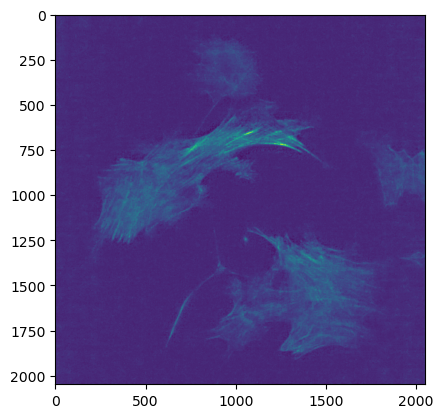

In [55]:
plt.imshow(pred_proc)

In [36]:
data_dict = get_saturation_factor(gt_img, pred_img)

(2048, 2048) (2048, 2048)
dict_keys(['SSIM', 'luminance', 'contrast', 'structure', 'alpha', 'ux', 'uy', 'vx', 'vy', 'vxy', 'C1', 'C2'])


In [37]:
data_dict['luminance'].shape

(2038, 2038)

<Axes: >

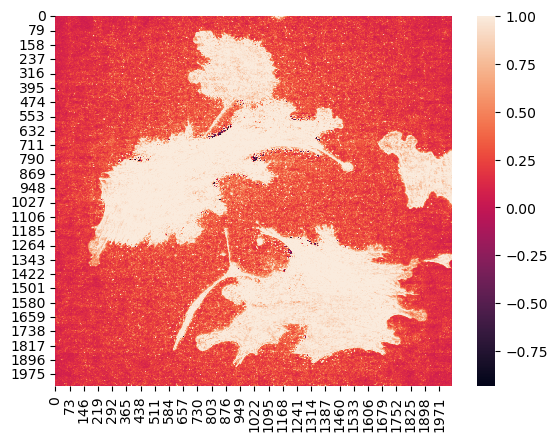

In [41]:
import seaborn as sns
sns.heatmap(data_dict['luminance'])

In [7]:
noise = get_noise(gt.shape)

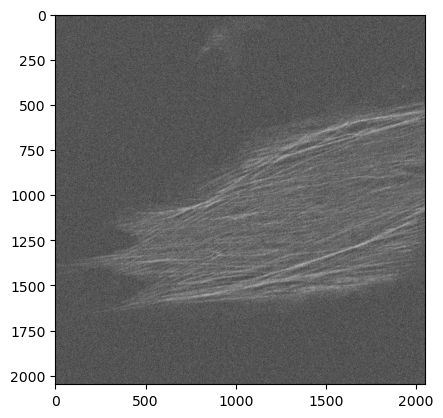

In [13]:
w = 0.1
idx = 33
plt.imshow((1-w)*noise[idx] + w*pred[idx], cmap='gray')

In [27]:
ncount = 20
gt_sub = gt[:ncount]
pred_sub = pred[:ncount]
noise_sub = noise[:ncount]
alphas = [1.0,0.5]

tmp_gt = []
tmp_pred = []
for alpha in alphas:
    tmp_gt.append(gt_sub)
    tmp_pred.append(alpha*pred_sub + (1-alpha)*noise_sub)

tmp_gt = np.concatenate(tmp_gt, axis=0)
tmp_pred = np.concatenate(tmp_pred, axis=0)

In [28]:
ssim = MicroMS3IM()
ssim.fit(tmp_gt, tmp_pred)


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


In [29]:
scores = [ssim.score(tmp_gt[i], tmp_pred[i]) for i in range(len(tmp_gt))]

In [32]:
np.mean(scores[ncount:])

0.79142606

In [ ]:
save_to_file = True and not debug_mode
alpha_list = np.arange(0,1.01,0.33)[::-1]
noise_as_pred = True
ncols = len(alpha_list) +2
nrows = len(locations)
_,ax = plt.subplots(figsize=(ncols*3,nrows*3), ncols=ncols, nrows=nrows)
for i, loc in enumerate(locations):
    gt_tmp = gt[loc.n_idx, loc.hs:loc.he, loc.ws:loc.we]
    gt_lowsnr_tmp = gt_lowsnr[loc.n_idx, loc.hs:loc.he, loc.ws:loc.we]
    pred_tmp = pred[loc.n_idx, loc.hs:loc.he, loc.ws:loc.we]
    
    if noise_as_pred:
        wrong_pred_tmp = get_noise(gt_tmp.shape)
    else:
        wrong_pred_tmp = pred[locations[(i+1)%2].n_idx, locations[(i+1)%2].hs:locations[(i+1)%2].he, locations[(i+1)%2].ws:locations[(i+1)%2].we]#
    
    ax[i,-1].imshow(gt_tmp, cmap='magma')
    ax[i,0].imshow(gt_lowsnr_tmp, cmap='magma')
    for j, alpha in enumerate(alpha_list):
        pred_alpha = pred_tmp*alpha + wrong_pred_tmp*(1-alpha)
        ax[i,j+1].imshow(pred_alpha, cmap='magma')
        if i ==0:
            ax[0,j+1].set_title(f'w={alpha:.2f}', fontsize=14)
        ssim_val = micro_SSIM(gt_tmp , pred_alpha, ri_factor=1.0, 
                       data_range=gt_tmp.max() - gt_tmp.min(),
                       return_individual_components=False)

        microssim_val = msssim.score(gt_tmp, pred_alpha, return_individual_components=False)
        # ax[i,j+1].set_title(f'{alpha:.2f} {ssim_val:.2f} {microssim_val:.2f}')    
        add_metric_text(ax[i,j+1], f'        SSIM:{ssim_val:.3f}\nMicroSSIM:{microssim_val:.3f}', gt_tmp.shape, place='TOP_LEFT')

ax[0,0].set_title('Low SNR Input', fontsize=14)
ax[0,-1].set_title('High SNR GT', fontsize=14)
clean_ax(ax)
# reduce white space between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ablation_noise_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)